# Time-Dependent Variational Principle (TDVP)
This notebook demonstrates the capabilities of out implemented TDVP algorithm, if the underlying tensor network structure is a chain, i.e. in matrix product form.

In [1]:
from copy import deepcopy

# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

X, Y, Z = ptn.common_operators.pauli_matrices()

## TDVP: A single qubit rotation on a Bloch Sphere
We use a simple Hamiltonian $H=X$ on a single qubit that is initially in the zero state $\ket{\psi} = \ket{0}$.

In [2]:
state = ptn.TreeTensorNetworkState()
tensor = np.array([1,0],dtype=complex)
single_node = ptn.Node(identifier="qubit")
state.add_root(single_node,tensor)
print(state.nodes)
print(state.tensors)

{'qubit': <pytreenet.node.Node object at 0x7f151eeeeb50>}
{'qubit': array([1.+0.j, 0.+0.j])}


In [3]:
ham = ptn.TTNO()
single_ham_node = ptn.Node(identifier="qubit")
ham.add_root(single_ham_node, deepcopy(X))
print(ham.nodes)
print(ham.tensors)

{'qubit': <pytreenet.node.Node object at 0x7f151eeeefd0>}
{'qubit': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}


Then we set up the TDVP algorithm.

In [4]:
time_step_size = 0.001
final_time = 1
operators = ptn.TensorProduct({"qubit": Z})

In [5]:
tdvp = ptn.FirstOrderOneSiteTDVP(state, ham,time_step_size, final_time,
                                 operators)
tdvp.run(evaluation_time=10)

100%|██████████| 1001/1001 [00:00<00:00, 3711.26it/s]


Now we run an exact reference copmutation:

In [6]:
ref_state = np.array([1,0],dtype=complex)
ref_ham = X
operator = Z
num_time_steps = tdvp.num_time_steps
ref_results = np.zeros_like(tdvp.results)
for time_step in range(num_time_steps+1):
    if time_step != 0:
        ref_state = ptn.fast_exp_action(-1j*time_step_size*ref_ham, ref_state)
    if time_step % 10 == 0:
        ref_results[0,time_step//10] = np.conjugate(ref_state) @ operator @ ref_state
        ref_results[-1,time_step//10] = time_step * time_step_size

In [7]:
# All expectation values are real
print(np.allclose(np.imag(tdvp.results),np.zeros_like(tdvp.results)))
print(np.allclose(np.imag(ref_results),np.zeros_like(ref_results)))

times = np.real(tdvp.results[-1,:])
ref_results = np.real(ref_results[0,:])
tdvp_results = np.real(tdvp.results[0,:])

True
True


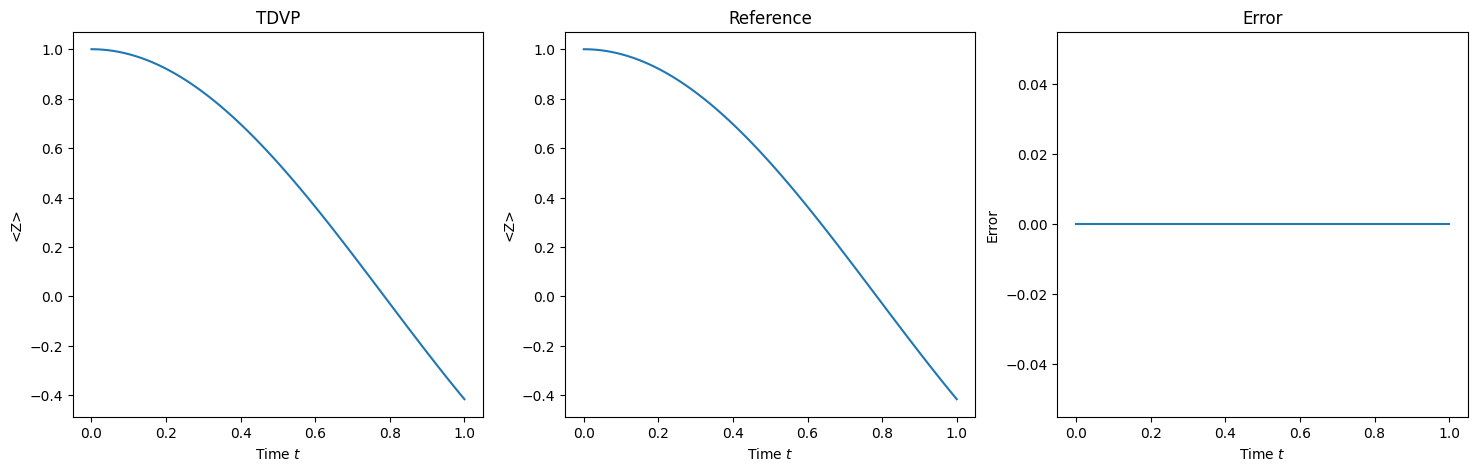

In [8]:
fig1, axs1 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs1[0].plot(times, tdvp_results)
axs1[0].set_xlabel("Time $t$")
axs1[0].set_ylabel("<Z>")
axs1[0].set_title("TDVP")

axs1[1].plot(times, ref_results)
axs1[1].set_xlabel("Time $t$")
axs1[1].set_ylabel("<Z>")
axs1[1].set_title("Reference")

axs1[2].plot(times, ref_results - tdvp_results)
axs1[2].set_xlabel("Time $t$")
axs1[2].set_ylabel("Error")
axs1[2].set_title("Error")

plt.show()

# TDVP with MPS: Two Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on two qubits given by
$$
H = -J X_0X_1 -g (Z_0 + Z_1),
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \ket{0}_0 \otimes \ket{0}_1
$$

In [9]:
num_sites = 2
mJ = -1.5
mg = -0.5

In [10]:
mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[1])
print(mps.nodes.keys())

dict_keys(['site0', 'site1'])


In [11]:
interaction_term = ptn.TensorProduct({"site0": "mJX", "site1": "X"})
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = [interaction_term]
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [12]:
hamiltonian = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
hamiltonian

[{'site0': 'mJX', 'site1': 'X'}, {'site0': 'mgZ', 'site1': 'I2'}, {'site1': 'mgZ', 'site0': 'I2'}]

In [13]:
ham_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, mps)
operators = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]

In [14]:
tdvp = ptn.FirstOrderOneSiteTDVP(mps,ham_ttno,
                                 time_step_size,final_time,
                                 operators)
tdvp.run(evaluation_time=10,pgbar=True)

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:01<00:00, 669.21it/s]


Now we run an exact reference simulation

In [15]:
ref_state = np.array([1,0,0,0],dtype=complex)
ref_ham = np.kron(conversion_dict["mJX"], conversion_dict["X"])
ref_ham += np.kron(conversion_dict["I2"], conversion_dict["mgZ"])
ref_ham += np.kron(conversion_dict["mgZ"], conversion_dict["I2"])
operator0 = np.kron(Z,np.eye(2))
operator1 = np.kron(np.eye(2),Z)
num_time_steps = tdvp.num_time_steps
ref_results = np.zeros_like(tdvp.results)
for time_step in range(num_time_steps+1):
    if time_step != 0:
        ref_state = ptn.fast_exp_action(-1j*time_step_size*ref_ham, ref_state)
    if time_step % 10 == 0:
        ref_results[0,time_step//10] = np.conjugate(ref_state) @ operator0 @ ref_state
        ref_results[1,time_step//10] = np.conjugate(ref_state) @ operator1 @ ref_state
        ref_results[-1,time_step//10] = time_step * time_step_size


In [16]:
# All expectation values are real
print(np.allclose(np.imag(tdvp.results),np.zeros_like(tdvp.results)))
print(np.allclose(np.imag(ref_results),np.zeros_like(ref_results)))

times = np.real(tdvp.results[-1,:])
ref_results0 = np.real(ref_results[0,:])
tdvp_results0 = np.real(tdvp.results[0,:])
ref_results1 = np.real(ref_results[1,:])
tdvp_results1 = np.real(tdvp.results[1,:])

True
True


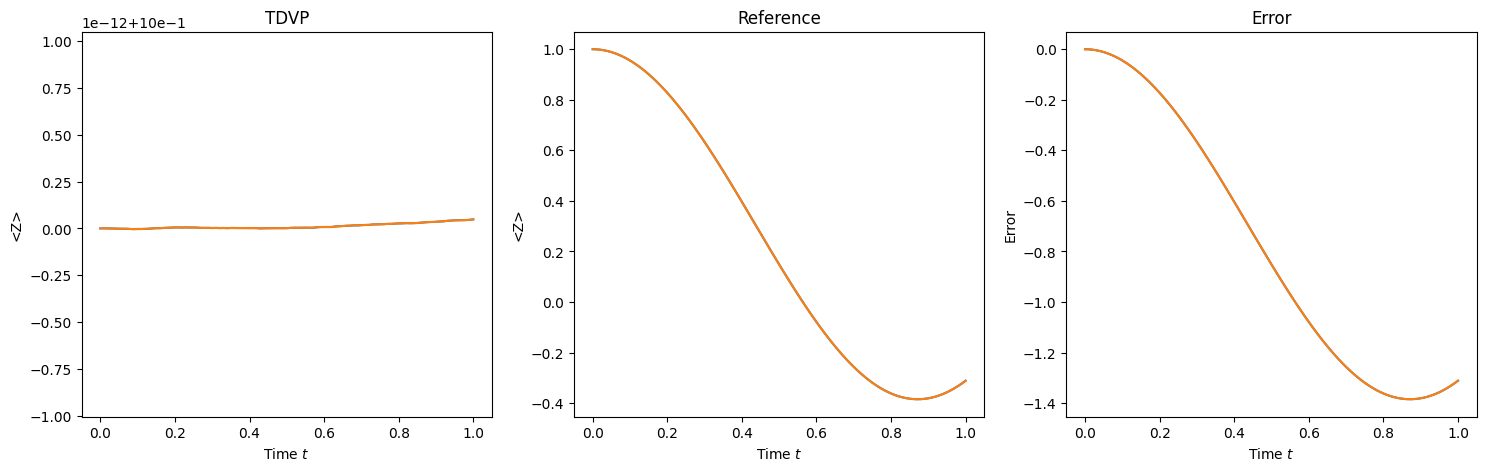

In [17]:
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp_results0)
axs2[0].plot(times, tdvp_results1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results0)
axs2[1].plot(times, ref_results1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, ref_results0 - tdvp_results0)
axs2[2].plot(times, ref_results1 - tdvp_results1)
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

The error is large, notably because we set the bond dimension to $1$, which is smaller than required. We repeat the process with bond dimension $2$:

In [18]:
mps2 = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
tdvp2 = ptn.FirstOrderOneSiteTDVP(mps2,ham_ttno,
                                 time_step_size,final_time,
                                 operators)
tdvp2.run(evaluation_time=10,pgbar=True)

100%|██████████| 1001/1001 [00:01<00:00, 589.22it/s]


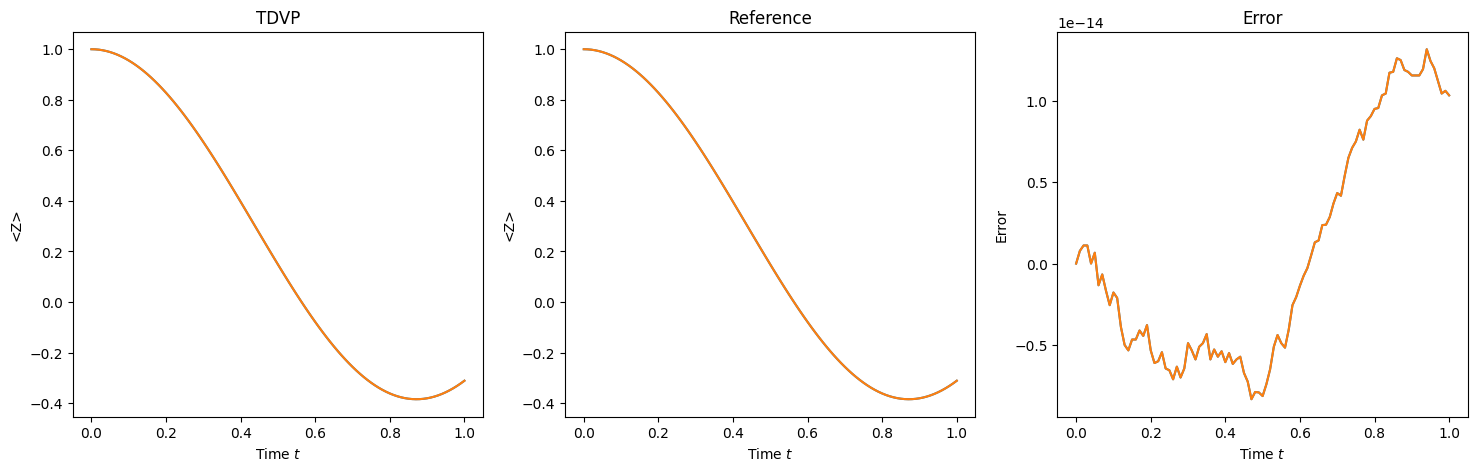

In [19]:
tdvp2_results0 = np.real(tdvp2.results[0,:])
tdvp2_results1 = np.real(tdvp2.results[1,:])
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results0)
axs2[0].plot(times, tdvp2_results1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results0)
axs2[1].plot(times, ref_results1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, ref_results0 - tdvp2_results0)
axs2[2].plot(times, ref_results1 - tdvp2_results1)
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()